In [15]:
import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt
from time import time

import localpsfcpp as lpsf

In [16]:
from nalger_helper_functions import plot_ellipse

(-0.25, 1.25)

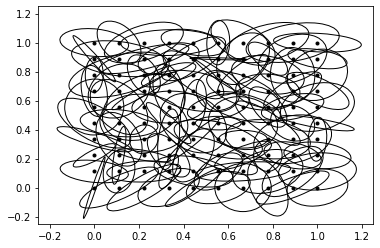

In [17]:
nx = 10
ny = 10
scaling_factor = 0.01
tau = 1.3
min_vol_rtol = 0.2

X, Y = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,nx))
pp = np.vstack([X.reshape(-1), Y.reshape(-1)])
num_ellipsoids = pp.shape[1]
all_vol = list(np.random.rand(num_ellipsoids))
all_mu = list(pp.T)
# all_mu = [np.random.rand(2) for _ in range(num_ellipsoids)]
all_Sigma = list()
for k in range(num_ellipsoids):
    S0 = np.random.randn(2,2)
    all_Sigma.append(scaling_factor * sla.sqrtm(np.dot(S0.T, S0)))

all_points = all_mu
    
for k in range(num_ellipsoids):
    plot_ellipse(all_mu[k], all_Sigma[k], tau)
    plt.plot(all_points[k][0], all_points[k][1], '.k')
    
plt.xlim(-0.25, 1.25)
plt.ylim(-0.25, 1.25)

(-0.25, 1.25)

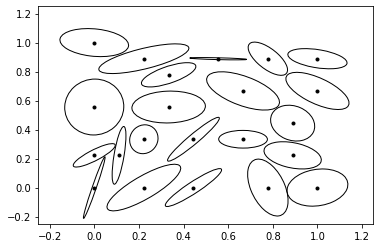

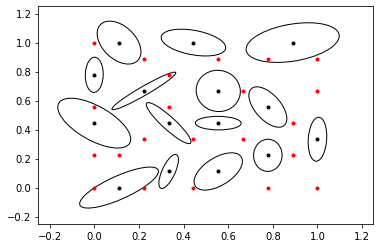

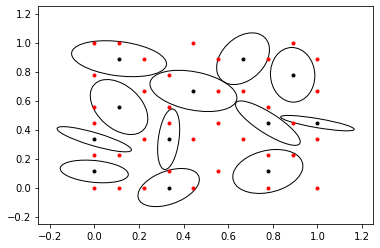

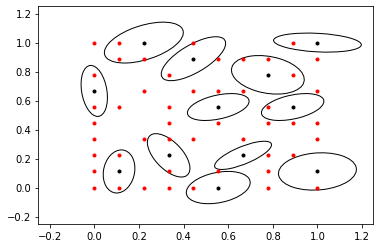

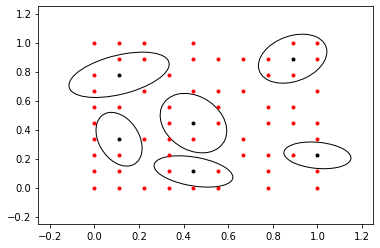

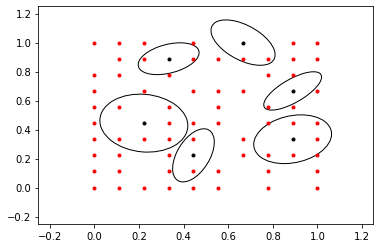

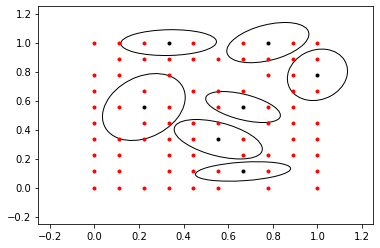

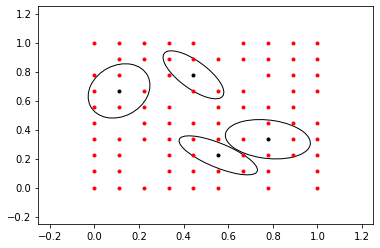

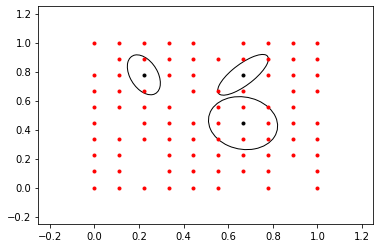

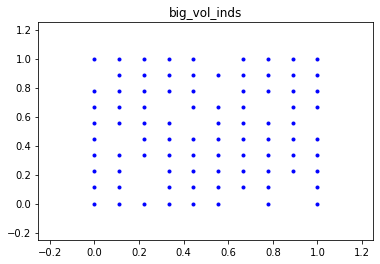

In [18]:
EPB = lpsf.EllipsoidBatchPicker(all_points, all_vol, all_mu, all_Sigma, tau, min_vol_rtol)

batch = EPB.pick_batch()
while batch:
#     print('EPB.batches=', EPB.batches)

    plt.figure()
    for b_old in EPB.batches[:-1]:
        for ind_old in b_old:
            plt.plot(all_points[ind_old][0], all_points[ind_old][1], '.r')
    
    for ind in batch:
        plot_ellipse(all_mu[ind], all_Sigma[ind], tau)
        plt.plot(all_points[ind][0], all_points[ind][1], '.k')

    plt.xlim(-0.25, 1.25)
    plt.ylim(-0.25, 1.25)
    
    batch = EPB.pick_batch()
    

big_vol_inds = (np.array(all_vol) > (min_vol_rtol * np.max(all_vol)))
plt.figure()
plt.plot(np.array(all_points)[big_vol_inds,0], np.array(all_points)[big_vol_inds,1], '.b')
plt.title('big_vol_inds')
plt.xlim(-0.25, 1.25)
plt.ylim(-0.25, 1.25)

In [20]:
num_ellipsoids = 10000
scaling_factor = 0.005
tau = 1.3
all_mu = [np.random.rand(2) for _ in range(num_ellipsoids)]
all_Sigma = list()
for k in range(num_ellipsoids):
    S0 = np.random.randn(2,2)
    all_Sigma.append(scaling_factor * sla.sqrtm(np.dot(S0.T, S0)))

all_points = all_mu
all_vol = list(np.random.rand(num_ellipsoids))

t = time()
EPB = lpsf.EllipsoidBatchPicker(all_points, all_vol, all_mu, all_Sigma, tau, min_vol_rtol)
dt_build = time() - t
print('num_ellipsoids=', num_ellipsoids, ', dt_build=', dt_build)

t = time()
for k in range(25):
    batch = EPB.pick_batch()
dt_batches = time() - t
print('num_ellipsoids=', num_ellipsoids, ', dt_batches=', dt_batches)

num_ellipsoids= 10000 , dt_build= 0.041307687759399414
num_ellipsoids= 10000 , dt_batches= 0.7618255615234375
